In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
is_interval_or_ratio = lambda column: type(next(iter(column))) != str and len(column) > 3

# Who Left
Pertama, muat data terlebih dahulu

In [3]:
hr_data = pd.read_csv('hr_data.csv')

Lalu, cari tahu kolom dan bentuk data tiap kolom.

In [18]:
hr_data[:5]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,NaN,0.53,2,157,3,0,1,0,sales,NaN
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,NaN,7,272,4,0,1,0,NaN,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### 1. Visualisasi
Untuk data nominal atau ordinal seperti `sales`, `salary`, `promotion_last_5years`, `left`, dan `work_accident`, histogram tidak dibuat.
Sebagai ganti, saya visualisasikan dengan bar chart.

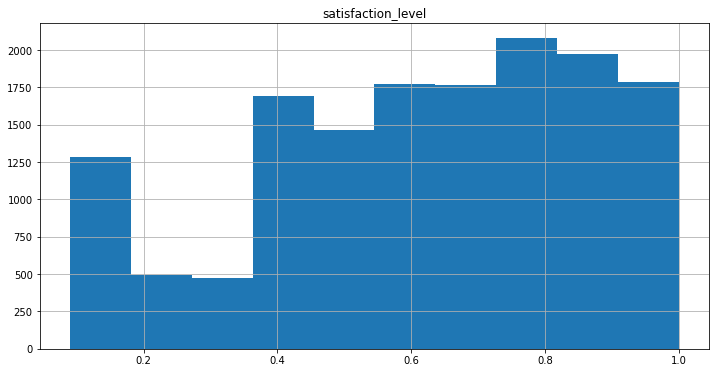

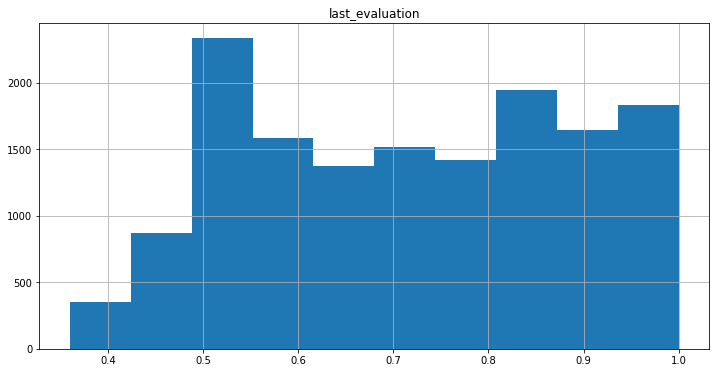

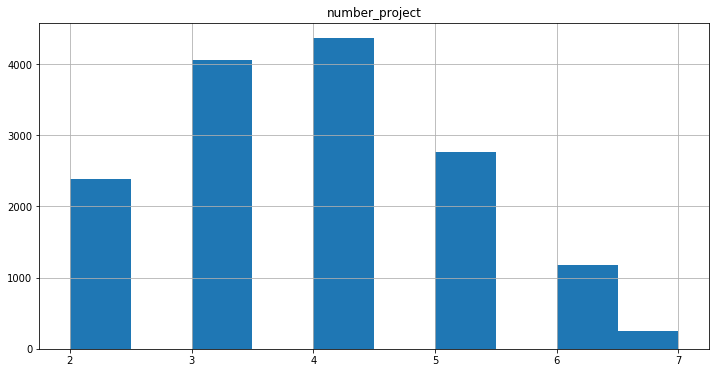

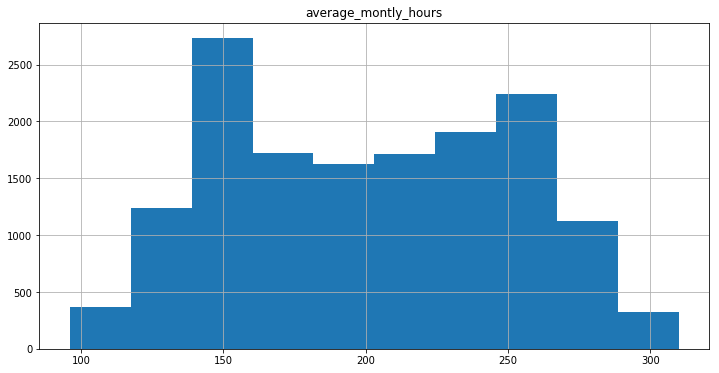

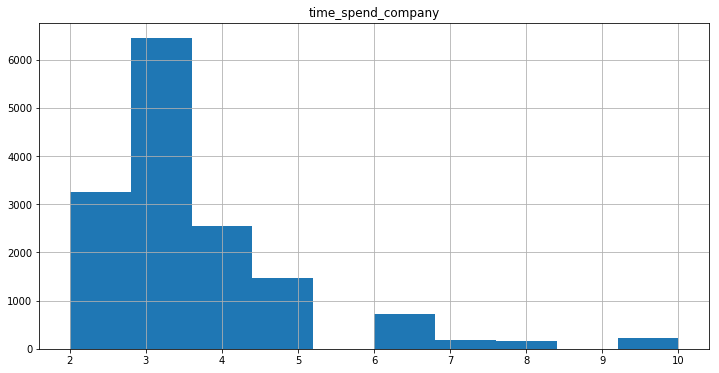

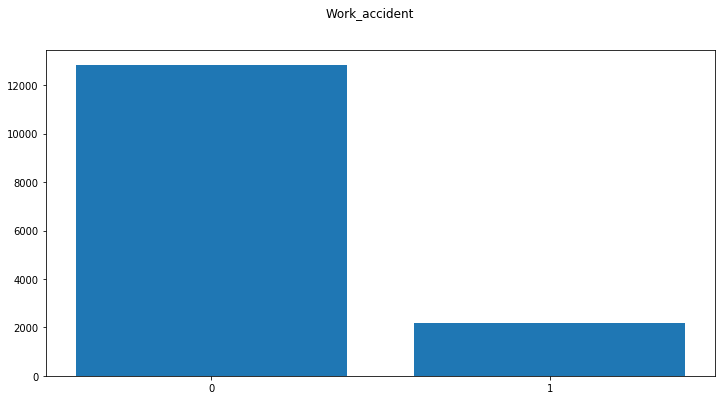

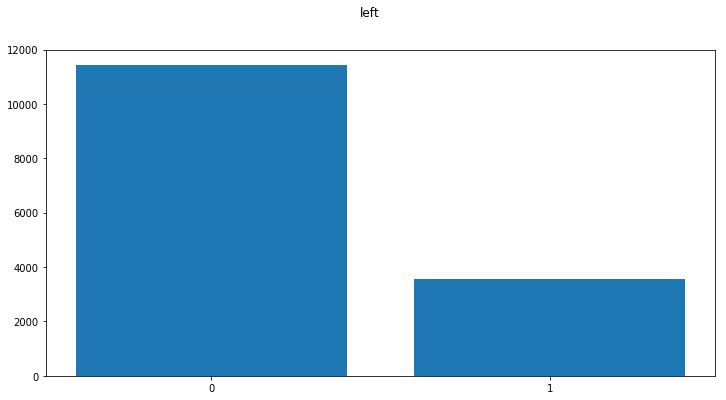

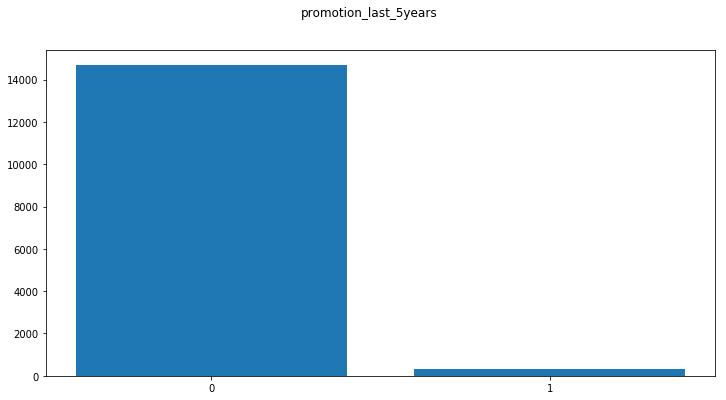

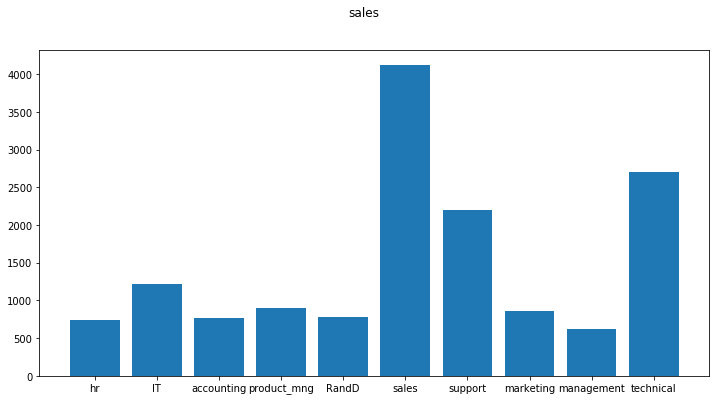

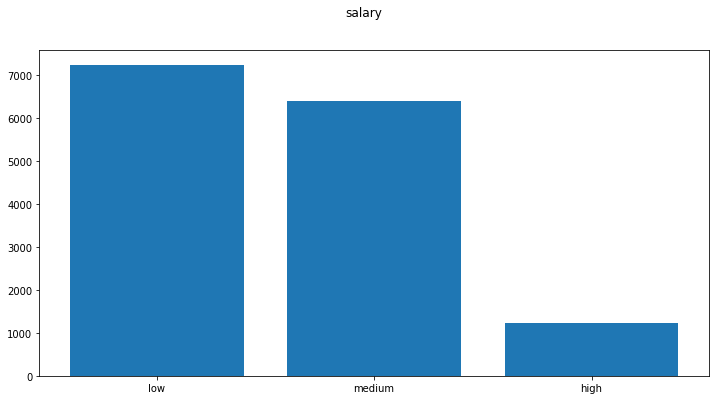

In [73]:
for c in hr_data.columns:
    column = set(hr_data[c].dropna())
    if is_interval_or_ratio(column):
        hr_data.hist(c, figsize=(12,6))
    else:
        fig = plt.figure(figsize=(12,6))
        counts = {str(s): len(hr_data.query('{} == "{}"'.format(c, s))) for s in column}
        plt.bar(counts.keys(), counts.values())
        fig.suptitle(c)

### 2. Outlier
Lagi-lagi, untuk atribut data nominal atau ordinal seperti `sales`, `salary`, `promotion_last_5years`, `left`, dan `work_accident`, outlier tidak dapat ditentukan.
Saya hanya visualisasikan outlier untuk atribut data interval dan rasio.

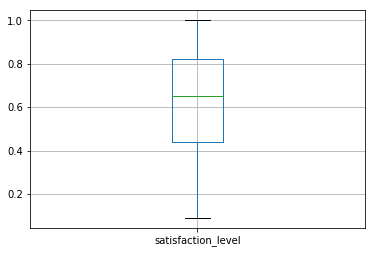

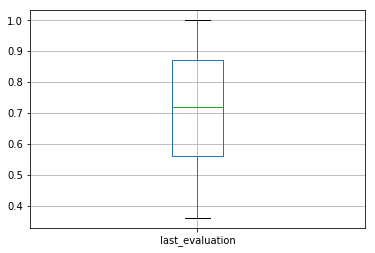

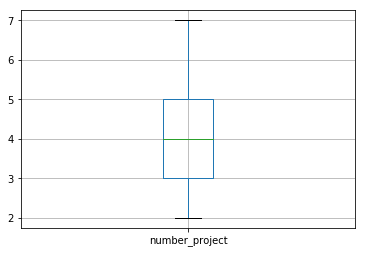

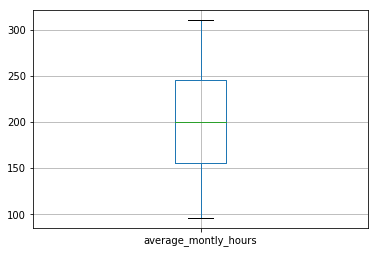

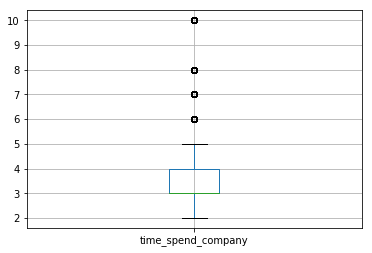

In [74]:
for c in hr_data.columns:
    column = set(hr_data[c].dropna())
    if is_interval_or_ratio(column):
        plt.figure()
        hr_data.boxplot(c)

Hanya atribut `time_spend_company` saja yang memiliki outlier

### 3. Pemisahan kolom fitur dan label target
Pemisahan kolom fitur dan kolom label

In [119]:
hr_data = pd.read_csv('hr_data.csv')
feature_columns = [c for c in hr_data.columns if c != 'left']
X = hr_data[feature_columns]
y = hr_data.left

Pada tahap ini soal menginstruksikan untuk memisah data test dan training

*TAPI* data test juga perlu preprocessing ***agar bisa dipakai untuk menguji model regresi***

Jadi dipisah nanti saja

### 4. Pengisian missing values pada data training

In [120]:
X = pd.DataFrame({**{
        c: X[c].fillna(X[c].median()) for c in X.columns if is_interval_or_ratio(set(X[c].dropna()))
    }, **{
        c: X[c].fillna('KOSONG') for c in X.columns if not is_interval_or_ratio(set(X[c].dropna()))
    }
})

Cek apakah label mengandung missing value

In [121]:
assert len(y) == len(y.dropna())

### 5. Handling data categorical

In [122]:
categorical_columns = ['sales', 'salary']
for cc in categorical_columns:
    X = X.join(pd.get_dummies(X[cc], prefix=cc))
numerical_columns = [c for c in X.columns if c not in categorical_columns]
X = X[numerical_columns]

In [123]:
X[:5]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_KOSONG,sales_RandD,...,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_KOSONG,salary_high,salary_low,salary_medium
0,0.65,0.53,2,157,3,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0.80,0.86,5,262,6,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0.11,0.72,7,272,4,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0.72,0.87,5,223,5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0.37,0.52,2,159,3,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


### 6. Normalisasi

Pada tahap ini baru saya pisah data training dan testing.

Karena jika normalisasi digabung, maka ketika dipisah, mean != 0

In [130]:
split = int(.7 * len(X))
X_train = np.array(X[:split])
y_train = np.array(y[:split])
X_test = np.array(X[split:])
y_test = np.array(y[split:])

In [131]:
scaler_train = StandardScaler()
scaler_train.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

Lakukan juga pada data testing

In [135]:
scaler_test = StandardScaler()
scaler_test.fit(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

### 7. Klasifikasi

##### 7.1 Logistic Regression

In [137]:
logistic_model = LogisticRegression()

In [138]:
logistic_model.fit(X_train, y_train)

C:\Users\yerla\AppData\Local\conda\conda\envs\dsa\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [177]:
logistic_model.score(X_train, y_train)

0.8206495856748262

In [139]:
logistic_model.score(X_test, y_test)

0.5984444444444444

Akurasi logistic regression = **60%**

##### 7.2 Random Forest Classifier

In [203]:
random_forest_model = RandomForestClassifier(random_state=0, n_estimators=100)

In [204]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [205]:
random_forest_model.score(X_train, y_train)

1.0

In [206]:
random_forest_model.score(X_test, y_test)

0.9213333333333333

Akurasi random forest classifer = **92%**

##### 7.3 AdaBoost Classifier

In [216]:
adaboost_model = AdaBoostClassifier(n_estimators=50)

In [217]:
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [218]:
adaboost_model.score(X_train, y_train)

0.9660920087627393

In [219]:
adaboost_model.score(X_test, y_test)

0.9117777777777778

Akurasi random forest classifer = **91%**